In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import warnings
import pandas as pd
warnings.filterwarnings('ignore')


In [4]:
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

In [7]:
df = pd.read_csv("E:/CTS/Medicare.csv") 

In [8]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

Dataset shape: (789, 48)
Columns: 48


In [9]:
df.head(3)

,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,C01: Breast Cancer Screening,C02: Colorectal Cancer Screening,C03: Annual Flu Vaccine,C04: Monitoring Physical Activity,C05: Special Needs Plan (SNP) Care Management,...,D04: Drug Plan Quality Improvement,D05: Rating of Drug Plan,D06: Getting Needed Prescription Drugs,D07: MPF Price Accuracy,D08: Medication Adherence for Diabetes Medications,D09: Medication Adherence for Hypertension (RAS antagonists),D10: Medication Adherence for Cholesterol (Statins),D11: MTM Program Completion Rate for CMR,D12: Statin Use in Persons with Diabetes (SUPD),Unnamed: 47
0,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,Plan not required to report measure,Plan not required to report measure,Plan not required to report measure,Plan not required to report measure,Plan not required to report measure,...,Medicare shows only a Star Rating for this topic,89,93,Not enough data available,89%,91%,89%,68%,86%,NaN
1,H0022,Demo,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Centene Corporation,No data available,No data available,No data available,No data available,No data available,...,No data available,No data available,No data available,No data available,No data available,No data available,No data available,No data available,No data available,NaN
2,H0028,Local CCP,"CHA HMO, INC.",Humana,Humana Inc.,76%,76%,67%,51%,80%,...,Medicare shows only a Star Rating for this topic,89,90,84,86%,90%,89%,86%,88%,s


In [10]:
print(df.dtypes)

CONTRACT_ID                                                                                              object
Organization Type                                                                                        object
Contract Name                                                                                            object
Organization Marketing Name                                                                              object
Parent Organization                                                                                      object
C01: Breast Cancer Screening                                                                             object
C02: Colorectal Cancer Screening                                                                         object
C03: Annual Flu Vaccine                                                                                  object
C04: Monitoring Physical Activity                                                                       

In [11]:
print(df.isnull().sum().sum(), "total missing values")

788 total missing values


In [12]:
print(df['Organization Type'].value_counts())

Organization Type
Local CCP                                   682
PDP                                          51
Demo                                         27
Regional CCP                                 16
1876 Cost                                     6
PFFS                                          4
MSA                                           2
Employer/Union Only Direct Contract PDP       1
Name: count, dtype: int64


In [13]:
print(df['Parent Organization'].value_counts().head(10))

Parent Organization
Centene Corporation                 79
UnitedHealth Group, Inc.            70
CVS Health Corporation              45
Elevance Health, Inc.               45
Humana Inc.                         38
Devoted Health, Inc.                33
Molina Healthcare, Inc.             22
The Cigna Group                     17
Health Care Service Corporation     13
Mitchell Family Office              12
Name: count, dtype: int64


In [14]:
measure_columns = [col for col in df.columns if re.match(r'^[CD]\d+', col)]
print(f"Found {len(measure_columns)} measure columns")

Found 42 measure columns


In [15]:
c_measures = [col for col in measure_columns if col.startswith('C')]
d_measures = [col for col in measure_columns if col.startswith('D')]

In [16]:
print(f"C measures: {len(c_measures)}")
print(f"D measures: {len(d_measures)}")
print("\nSample C measures:", c_measures[:5])
print("Sample D measures:", d_measures[:5])

C measures: 30
D measures: 12

Sample C measures: ['C01: Breast Cancer Screening', 'C02: Colorectal Cancer Screening', 'C03: Annual Flu Vaccine', 'C04: Monitoring Physical Activity', 'C05: Special Needs Plan (SNP) Care Management']
Sample D measures: ['D01: Call Center – Foreign Language Interpreter and TTY Availability', 'D02: Complaints about the Drug Plan', 'D03: Members Choosing to Leave the Plan', 'D04: Drug Plan Quality Improvement', 'D05: Rating of Drug Plan']


In [17]:
special_values = [
    'Plan not required to report measure',
    'Plan too small to be measured', 
    'No data available',
    'Not enough data available',
    'Not required to report',
    'Medicare shows only a Star Rating for this topic'
]

df_clean = df.copy()

In [18]:
for col in measure_columns:
    # Create flag column
    flag_col = f"{col}_flag"
    df_clean[flag_col] = 'valid'
    
    for special_val in special_values:
        mask = df_clean[col] == special_val
        df_clean.loc[mask, flag_col] = 'special'
        df_clean.loc[mask, col] = np.nan
    
    # Convert to numeric, handling percentage signs
    df_clean[col] = pd.to_numeric(df_clean[col].str.rstrip('%'), errors='coerce')

In [19]:
print("Conversion completed. Sample numeric values:")
print(df_clean['C01: Breast Cancer Screening'].head())

Conversion completed. Sample numeric values:
0     NaN
1     NaN
2    76.0
3     NaN
4    47.0
Name: C01: Breast Cancer Screening, dtype: float64


In [20]:
completeness = {}
for col in measure_columns:
    complete = df_clean[col].notna().sum()
    total = len(df_clean)
    completeness[col] = {
        'complete_count': complete,
        'completeness_pct': (complete / total) * 100
    }


In [21]:
completeness_df = pd.DataFrame(completeness).T
completeness_df = completeness_df.sort_values('completeness_pct', ascending=False)

In [24]:
print("Measures with best data completeness:")
print(completeness_df.head(5))

Measures with best data completeness:
                                                    complete_count  \
D01: Call Center – Foreign Language Interpreter...           674.0   
D10: Medication Adherence for Cholesterol (Stat...           659.0   
D09: Medication Adherence for Hypertension (RAS...           655.0   
C30: Call Center – Foreign Language Interpreter...           651.0   
D07: MPF Price Accuracy                                      650.0   

                                                    completeness_pct  
D01: Call Center – Foreign Language Interpreter...         85.424588  
D10: Medication Adherence for Cholesterol (Stat...         83.523447  
D09: Medication Adherence for Hypertension (RAS...         83.016477  
C30: Call Center – Foreign Language Interpreter...         82.509506  
D07: MPF Price Accuracy                                    82.382763  


In [25]:
print("\nMeasures with worst data completeness:")
print(completeness_df.tail(5))


Measures with worst data completeness:
                                                    complete_count  \
C07: Care for Older Adults – Pain Assessment                 333.0   
C06: Care for Older Adults – Medication Review               333.0   
C08: Osteoporosis Management in Women who had a...           315.0   
C27: Health Plan Quality Improvement                           0.0   
D04: Drug Plan Quality Improvement                             0.0   

                                                    completeness_pct  
C07: Care for Older Adults – Pain Assessment               42.205323  
C06: Care for Older Adults – Medication Review             42.205323  
C08: Osteoporosis Management in Women who had a...         39.923954  
C27: Health Plan Quality Improvement                        0.000000  
D04: Drug Plan Quality Improvement                          0.000000  


In [26]:
df_clean['data_completeness_score'] = df_clean[measure_columns].notna().mean(axis=1)
df_clean['has_meaningful_data'] = df_clean[measure_columns].notna().any(axis=1)

print(f"\nPlans with meaningful data: {df_clean['has_meaningful_data'].sum()}/{len(df_clean)}")
print(f"Average data completeness: {df_clean['data_completeness_score'].mean():.1%}")


Plans with meaningful data: 715/789
Average data completeness: 61.6%


In [27]:
key_measures = [
    'C01: Breast Cancer Screening',
    'C02: Colorectal Cancer Screening', 
    'C10: Diabetes Care – Blood Sugar Controlled',
    'C11: Controlling High Blood Pressure',
    'C15: Plan All-Cause Readmissions',
    'D08: Medication Adherence for Diabetes Medications'
]

In [28]:
def plot_measure_distribution(measure_name):
    data = df_clean[measure_name].dropna()
    if len(data) > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=20, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of {measure_name}')
        plt.xlabel('Score (%)')
        plt.ylabel('Number of Plans')
        plt.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.1f}%')
        plt.axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.1f}%')
        plt.legend()
        plt.show()
        
        print(f"{measure_name}:")
        print(f"  Mean: {data.mean():.2f}%")
        print(f"  Median: {data.median():.2f}%")
        print(f"  Std: {data.std():.2f}%")
        print(f"  Range: {data.min():.2f}% - {data.max():.2f}%")
        print(f"  Plans with data: {len(data)}")
        print()

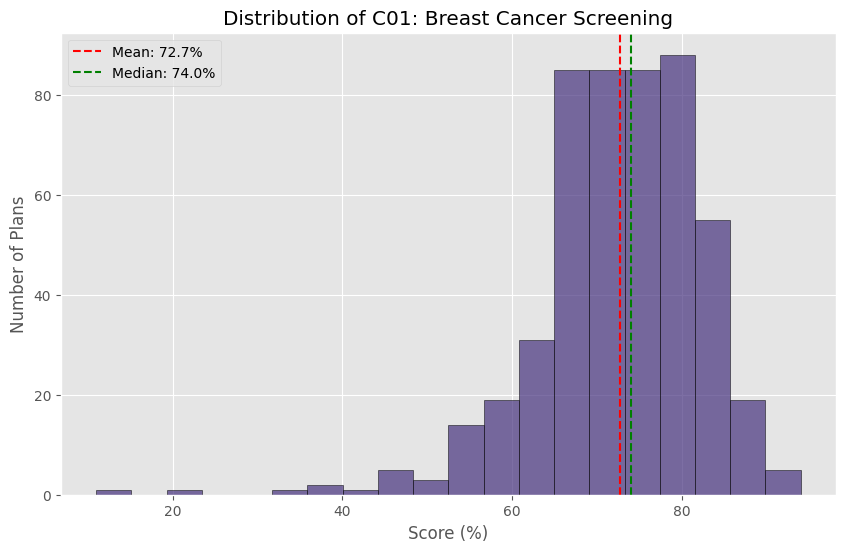

C01: Breast Cancer Screening:
  Mean: 72.68%
  Median: 74.00%
  Std: 9.72%
  Range: 11.00% - 94.00%
  Plans with data: 500



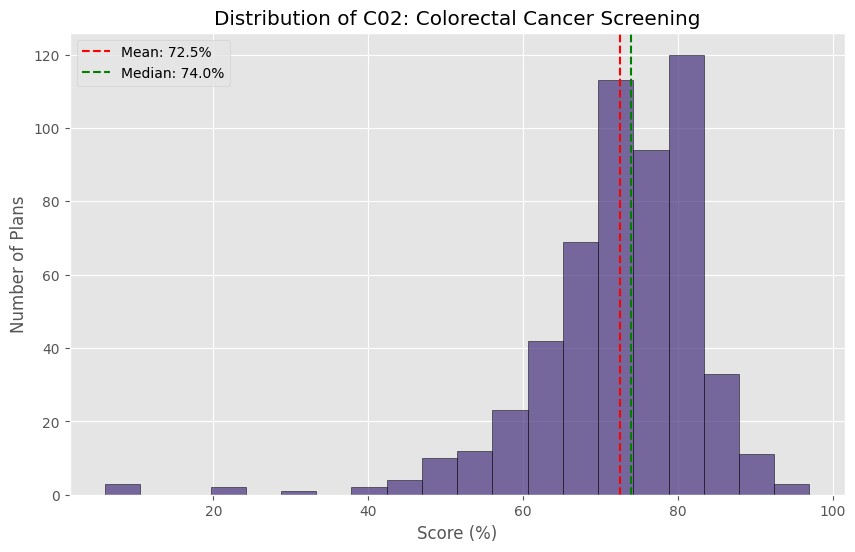

C02: Colorectal Cancer Screening:
  Mean: 72.54%
  Median: 74.00%
  Std: 10.99%
  Range: 6.00% - 97.00%
  Plans with data: 542



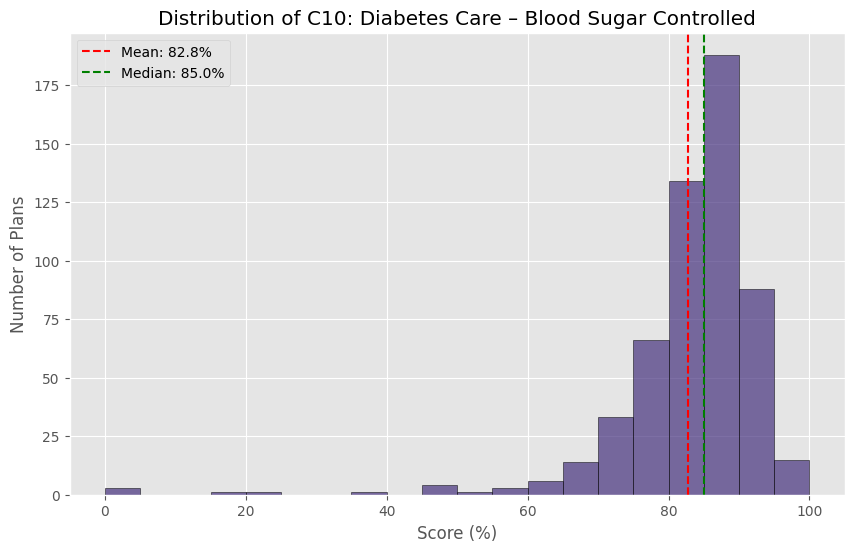

C10: Diabetes Care – Blood Sugar Controlled:
  Mean: 82.80%
  Median: 85.00%
  Std: 10.62%
  Range: 0.00% - 100.00%
  Plans with data: 558



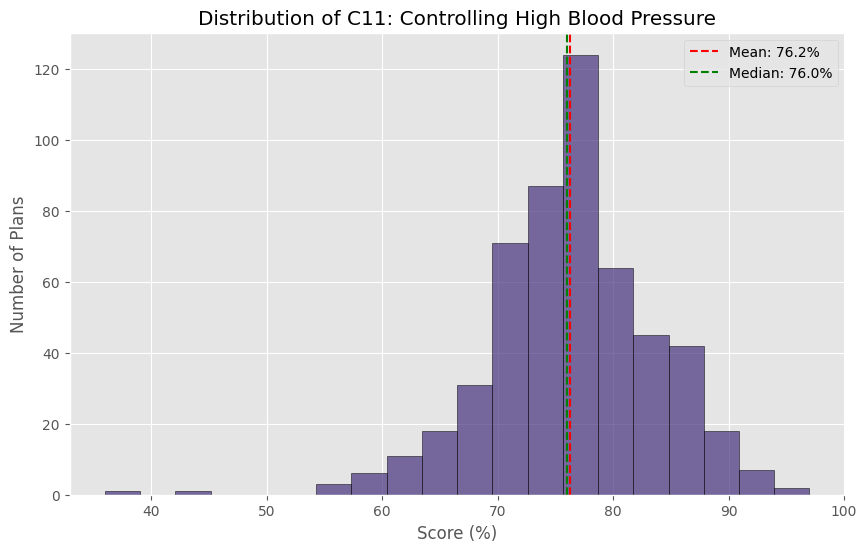

C11: Controlling High Blood Pressure:
  Mean: 76.24%
  Median: 76.00%
  Std: 7.13%
  Range: 36.00% - 97.00%
  Plans with data: 531



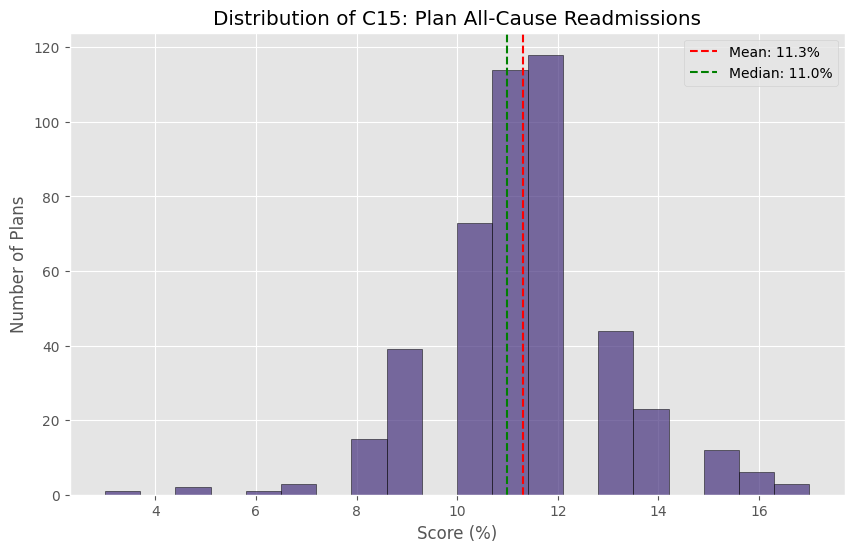

C15: Plan All-Cause Readmissions:
  Mean: 11.30%
  Median: 11.00%
  Std: 1.81%
  Range: 3.00% - 17.00%
  Plans with data: 454



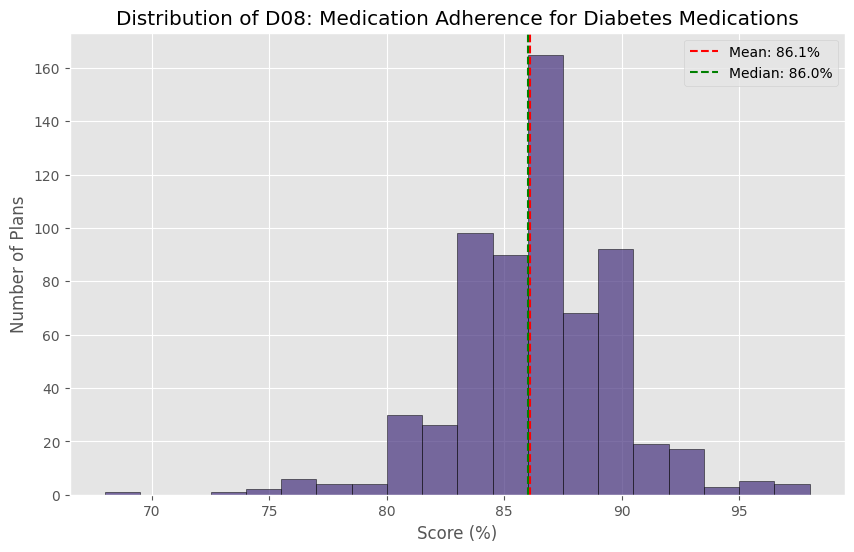

D08: Medication Adherence for Diabetes Medications:
  Mean: 86.11%
  Median: 86.00%
  Std: 3.48%
  Range: 68.00% - 98.00%
  Plans with data: 635



In [29]:
for measure in key_measures:
    if measure in df_clean.columns:
        plot_measure_distribution(measure)

In [32]:
# Calculate overall score (average of available measures)
df_clean['overall_score'] = df_clean[measure_columns].mean(axis=1)

# Top performers
top_10 = df_clean.nlargest(10, 'overall_score')[['CONTRACT_ID', 'Contract Name', 'overall_score']]
print("Top 10 Performers:")
print(top_10.round(1))

# Bottom performers (with sufficient data)
bottom_10 = df_clean[df_clean['data_completeness_score'] > 0.5].nsmallest(10, 'overall_score')[
    ['CONTRACT_ID', 'Contract Name', 'overall_score', 'data_completeness_score']]
print("\nBottom 10 Performers (with sufficient data):")
print(bottom_10.round(1))


Top 10 Performers:
    CONTRACT_ID                                     Contract Name  \
199      H2715                 MOLINA HEALTHCARE OF ILLINOIS INC    
217      H3038                   MOLINA HEALTHCARE OF CALIFORNIA    
340      H4471   BLUE CROSS OF CALIFORNIA PARTNERSHIP PLAN, INC.    
361      H4704     ANTHEM BLUE CROSS LIFE AND HEALTH INS COMPANY    
181      H2478                   MOLINA HEALTHCARE OF NEVADA INC    
52       H0845                UNITEDHEALTHCARE OF ILLINOIS, INC.    
87       H1339       JOHNS HOPKINS HEALTH PLAN OF VIRGINIA, INC.    
225      H3138               KAISER PERMANENTE INSURANCE COMPANY    
358      H4661                          CELTIC INSURANCE COMPANY    
643      H8794                        KAISER FOUNDATION HP, INC.    

     overall_score  
199          100.0  
217          100.0  
340          100.0  
361          100.0  
181           99.7  
52            99.0  
87            99.0  
225           99.0  
358           99.0  
643        

In [33]:
print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total plans: {len(df_clean)}")
print(f"   - Plans with meaningful data: {df_clean['has_meaningful_data'].sum()}")
print(f"   - Average data completeness: {df_clean['data_completeness_score'].mean():.1%}")


1. DATASET OVERVIEW:
   - Total plans: 789
   - Plans with meaningful data: 715
   - Average data completeness: 61.6%


In [34]:
print(f"\n2. PERFORMANCE SUMMARY:")
avg_score = df_clean['overall_score'].mean()
print(f"   - Average overall score: {avg_score:.1f}%")
print(f"   - Score range: {df_clean['overall_score'].min():.1f}% - {df_clean['overall_score'].max():.1f}%")


2. PERFORMANCE SUMMARY:
   - Average overall score: 73.6%
   - Score range: 46.4% - 100.0%


In [35]:
# Find best and worst performing measures
measure_avgs = df_clean[measure_columns].mean().sort_values(ascending=False)
best_measure = measure_avgs.idxmax()
worst_measure = measure_avgs.idxmin()

In [36]:
print(f"\n3. KEY INSIGHTS:")
print(f"   - Strongest measure: {best_measure} ({measure_avgs.max():.1f}%)")
print(f"   - Weakest measure: {worst_measure} ({measure_avgs.min():.1f}%)")
print(f"   - Most complete measure: {completeness_df['completeness_pct'].idxmax()} ({completeness_df['completeness_pct'].max():.1f}% complete)")
print(f"   - Least complete measure: {completeness_df['completeness_pct'].idxmin()} ({completeness_df['completeness_pct'].min():.1f}% complete)")


3. KEY INSIGHTS:
   - Strongest measure: D07: MPF Price Accuracy (97.6%)
   - Weakest measure: D02: Complaints about the Drug Plan (0.2%)
   - Most complete measure: D01: Call Center – Foreign Language Interpreter and TTY Availability (85.4% complete)
   - Least complete measure: C27: Health Plan Quality Improvement (0.0% complete)


In [37]:
print(f"\n4. RECOMMENDATIONS:")
print("   - Focus improvement efforts on measures with lowest scores")
print("   - Investigate plans with poor performance for root causes")
print("   - Analyze temporal trends for key measures")
print("   - Use correlation insights for coordinated improvement strategies")


4. RECOMMENDATIONS:
   - Focus improvement efforts on measures with lowest scores
   - Investigate plans with poor performance for root causes
   - Analyze temporal trends for key measures
   - Use correlation insights for coordinated improvement strategies


In [38]:
# Save cleaned data for further analysis
df_clean.to_csv('medicare_star_ratings_cleaned.csv', index=False)
print(f"\nCleaned data saved to 'medicare_star_ratings_cleaned.csv'")


Cleaned data saved to 'medicare_star_ratings_cleaned.csv'
